[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/edit-state-human-feedback.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239520-lesson-3-editing-state-and-human-feedback)

# Editing graph state

## Review

We discussed motivations for human-in-the-loop:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

We showed how breakpoints support user approval, but don't yet know how to modify our graph state once our graph is interrupted!

## Goals

Now, let's show how to directly edit the graph state and insert human feedback.

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_ollama import ChatOllama
model = ChatOllama(model="granite3.3:8b", temperature=0)

## Editing state 

Previously, we introduced breakpoints.

We used them to interrupt the graph and await user approval before executing the next node.

But breakpoints are also [opportunities to modify the graph state](https://docs.langchain.com/oss/javascript/langgraph/use-time-travel#3-update-the-state).

Let's set up our agent with a breakpoint before the `assistant` node.

In [3]:
from langchain_openai import ChatOpenAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = model
llm_with_tools = llm.bind_tools(tools)

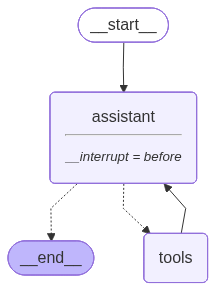

In [4]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

Let's run!

We can see the graph is interrupted before the chat model responds. 

In [5]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [6]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='2b5bc555-b2dc-4575-8b2e-fc5a51ccccd0')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f8614-f08f-61e5-8000-7a9abe24321c'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2026-01-23T13:42:06.998726+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f8614-f086-6f8e-bfff-ecfa0583c66c'}}, tasks=(PregelTask(id='cd056a76-1cb7-41a4-22d7-af6a62370617', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

Now, we can directly apply a state update.

Remember, updates to the `messages` key will use the `add_messages` reducer:
 
* If we want to over-write the existing message, we can supply the message `id`.
* If we simply want to append to our list of messages, then we can pass a message without an `id` specified, as shown below.

In [7]:
graph.update_state(
    thread,
    {"messages": [HumanMessage(content="No, actually multiply 3 and 3!")]},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0f8614-f114-6b8d-8001-2241a8990c19'}}

Let's have a look.

We called `update_state` with a new message. 

The `add_messages` reducer appends it to our state key, `messages`.

In [8]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, actually multiply 3 and 3!


Now, let's proceed with our agent, simply by passing `None` and allowing it proceed from the current state.

We emit the current and then proceed to execute the remaining nodes.

In [9]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 3 and 3!
================================== Ai Message ==================================

<function_call>{"name": "multiply", "arguments": {"a": 3, "b": 3}}</function_call>


Now, we're back at the `assistant`, which has our `breakpoint`.

We can again pass `None` to proceed.

In [10]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================

<function_call>{"name": "multiply", "arguments": {"a": 3, "b": 3}}</function_call>


### Editing graph state in Studio

**⚠️ Notice**

Since filming these videos, we've updated Studio so that it can now be run locally and accessed through your browser. This is the preferred way to run Studio instead of using the Desktop App shown in the video. It is now called _LangSmith Studio_ instead of _LangGraph Studio_. Detailed setup instructions are available in the "Getting Setup" guide at the start of the course. You can find a description of Studio [here](https://docs.langchain.com/langsmith/studio), and specific details for local deployment [here](https://docs.langchain.com/langsmith/quick-start-studio#local-development-server).  
To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the **Studio UI** URL shown above.

The LangGraph API [supports editing graph state](https://docs.langchain.com/langsmith/add-human-in-the-loop). 

In [11]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [12]:
# This is the URL of the local development server
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

Our agent is defined in `studio/agent.py`. 

If you look at the code, you'll see that it *does not* have a breakpoint! 
 
Of course, we can add it to `agent.py`, but one very nice feature of the API is that we can pass in a breakpoint!

Here, we pass a `interrupt_before=["assistant"]`.

In [13]:
initial_input = {"messages": "Multiply 2 and 3"}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    "agent",
    input=initial_input,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '713702a9-21cc-4432-bcaf-71c8a6acaa87'}
--------------------------------------------------


We can get the current state

In [14]:
current_state = await client.threads.get_state(thread['thread_id'])
current_state

{'values': {'messages': [{'content': 'Multiply 2 and 3',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '713702a9-21cc-4432-bcaf-71c8a6acaa87'}]},
 'next': ['assistant'],
 'tasks': [{'id': 'a57d0af4-5aba-e7bb-d8b1-63315497ccc0',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': None}],
 'metadata': {'graph_id': 'agent',
  'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'user_id': '',
  'created_by': 'system',
  'run_attempt': 1,
  'langgraph_version': '1.0.6',
  'langgraph_api_version': '0.6.39',
  'langgraph_plan': 'developer',
  'langgraph_host': 'self-hosted',
  'langgraph_api_url': 'http://127.0.0.1:2024',
  'run_id': '019beb17-6e16-7d13-870d-cda0ad625d64',
  'thread_id': '4ef13e30-e10f-439c-b649-d64f69c3e8bd',
  'source': 'loop',
  'step': 0,
  'parents': {},
  'langgraph_request_id': '9bd38417-7df4-48cf

We can look at the last message in state.

In [15]:
last_message = current_state['values']['messages'][-1]
last_message

{'content': 'Multiply 2 and 3',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '713702a9-21cc-4432-bcaf-71c8a6acaa87'}

We can edit it!

In [16]:
last_message['content'] = "No, actually multiply 3 and 3!"
last_message

{'content': 'No, actually multiply 3 and 3!',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '713702a9-21cc-4432-bcaf-71c8a6acaa87'}

In [17]:
last_message

{'content': 'No, actually multiply 3 and 3!',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': '713702a9-21cc-4432-bcaf-71c8a6acaa87'}

Remember, as we said before, updates to the `messages` key will use the same `add_messages` reducer. 

If we want to over-write the existing message, then we can supply the message `id`.

Here, we did that. We only modified the message `content`, as shown above.

In [18]:
await client.threads.update_state(thread['thread_id'], {"messages": last_message})

{'checkpoint': {'thread_id': '4ef13e30-e10f-439c-b649-d64f69c3e8bd',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0f8615-7506-681e-8001-6666a11031af'},
 'configurable': {'thread_id': '4ef13e30-e10f-439c-b649-d64f69c3e8bd',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0f8615-7506-681e-8001-6666a11031af'},
 'checkpoint_id': '1f0f8615-7506-681e-8001-6666a11031af'}

Now, we resume by passing `None`. 

In [19]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': 'No, actually multiply 3 and 3!', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '713702a9-21cc-4432-bcaf-71c8a6acaa87'}
--------------------------------------------------
Receiving new event of type: values...
{'content': '```python\n{\n  "function": "multiply",\n  "arguments": {\n    "a": 3,\n    "b": 3\n  }\n}\n```', 'additional_kwargs': {}, 'response_metadata': {'model': 'granite3.3:8b', 'created_at': '2026-01-23T13:43:17.819441261Z', 'done': True, 'done_reason': 'stop', 'total_duration': 55793729997, 'load_duration': 45374317, 'prompt_eval_count': 219, 'prompt_eval_duration': 43617498777, 'eval_count': 36, 'eval_duration': 12077113403, 'logprobs': None, 'model_name': 'granite3.3:8b', 'model_provider': 'ollama'}, 'type': 'ai', 'name': None, 'id': 'lc_run--019beb17-761f-75b3-b531-2ce6e61d7cb4-0', 'tool_

We get the result of the tool call as `9`, as expected.

In [20]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    interrupt_before=["assistant"],
):
    print(f"Receiving new event of type: {chunk.event}...")
    messages = chunk.data.get('messages', [])
    if messages:
        print(messages[-1])
    print("-" * 50)

Receiving new event of type: metadata...
--------------------------------------------------
Receiving new event of type: values...
{'content': '```python\n{\n  "function": "multiply",\n  "arguments": {\n    "a": 3,\n    "b": 3\n  }\n}\n```', 'additional_kwargs': {}, 'response_metadata': {'model': 'granite3.3:8b', 'created_at': '2026-01-23T13:43:17.819441261Z', 'done': True, 'done_reason': 'stop', 'total_duration': 55793729997, 'load_duration': 45374317, 'prompt_eval_count': 219, 'prompt_eval_duration': 43617498777, 'eval_count': 36, 'eval_duration': 12077113403, 'logprobs': None, 'model_name': 'granite3.3:8b', 'model_provider': 'ollama'}, 'type': 'ai', 'name': None, 'id': 'lc_run--019beb17-761f-75b3-b531-2ce6e61d7cb4-0', 'tool_calls': [], 'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 219, 'output_tokens': 36, 'total_tokens': 255}}
--------------------------------------------------


## Awaiting user input

So, it's clear that we can edit our agent state after a breakpoint.

Now, what if we want to allow for human feedback to perform this state update?

We'll add a node that serves as a placeholder for human feedback within our agent.

This `human_feedback` node allow the user to add feedback directly to state.
 
We specify the breakpoint using `interrupt_before` our `human_feedback` node.

We set up a checkpointer to save the state of the graph up until this node.

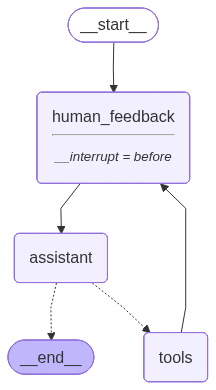

In [21]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# no-op node that should be interrupted on
def human_feedback(state: MessagesState):
    pass

# Assistant node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

We will get feedback from the user.

We use `.update_state` to update the state of the graph with the human response we get, as before.

We use the `as_node="human_feedback"` parameter to apply this state update as the specified node, `human_feedback`.

In [22]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()
    
# Get user input
user_input = input("Tell me how you want to update the state: ")

# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"messages": user_input}, as_node="human_feedback")

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


Tell me how you want to update the state:  No, actually multiply 3 and 3!


================================ Human Message =================================

No, actually multiply 3 and 3!
================================== Ai Message ==================================

<function_call>{"name": "multiply", "arguments": {"a": 3, "b": 3}}</function_call>


In [23]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================

<function_call>{"name": "multiply", "arguments": {"a": 3, "b": 3}}</function_call>
